In [62]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

In [70]:
mnist = input_data.read_data_sets("MNIST_data", one_hot=True)

# 创建一个交互式的Session。
sess = tf.InteractiveSession()

# 创建两个占位符，数据类型是float。x占位符的形状是[None，784]，即用来存放图像数据的变量，图像有多少张
# 是不关注的。但是图像的数据维度有784围。怎么来的，因为MNIST处理的图片都是28*28的大小，将一个二维图像
# 展平后，放入一个长度为784的数组中。
# y_占位符的形状类似x，只是维度只有10，因为输出结果是0-9的数字，所以只有10种结构。
x = tf.placeholder("float", shape=[None, 784])
y_ = tf.placeholder("float", shape=[None, 10])


# 通过函数的形式定义权重变量。变量的初始值，来自于截取正态分布中的数据。
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)


# 通过函数的形式定义偏置量变量，偏置的初始值都是0.1，形状由shape定义。
def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)


# 定义卷积函数，其中x是输入，W是权重，也可以理解成卷积核，strides表示步长，或者说是滑动速率，包含长宽方向
# 的步长。padding表示补齐数据。 目前有两种补齐方式，一种是SAME，表示补齐操作后（在原始图像周围补充0），实
# 际卷积中，参与计算的原始图像数据都会参与。一种是VALID，补齐操作后，进行卷积过程中，原始图片中右边或者底部
# 的像素数据可能出现丢弃的情况。
def conv2d(x, w):
  return tf.nn.conv2d(x, w, strides=[1, 1, 1, 1], padding='SAME')


# 这步定义函数进行池化操作，在卷积运算中，是一种数据下采样的操作，降低数据量，聚类数据的有效手段。常见的
# 池化操作包含最大值池化和均值池化。这里的2*2池化，就是每4个值中取一个，池化操作的数据区域边缘不重叠。
# 函数原型：def max_pool(value, ksize, strides, padding, data_format="NHWC", name=None)。对ksize和strides
# 定义的理解要基于data_format进行。默认NHWC，表示4维数据，[batch,height,width,channels]. 下面函数中的ksize，
# strides中，每次处理都是一张图片，对应的处理数据是一个通道（例如，只是黑白图片）。长宽都是2，表明是2*2的
# 池化区域，也反应出下采样的速度。
def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

# 定义第一层卷积核。shape在这里，对应卷积核filter。
# 其中filter的结构为：[filter_height, filter_width, in_channels, out_channels]。这里，卷积核的高和宽都是5，
# 输入通道1，输出通道数为32，也就是说，有32个卷积核参与卷积。
W_conv1 = weight_variable([5, 5, 1, 32])
# 偏置量定义，偏置的维度是32.
b_conv1 = bias_variable([32])

# 将输入tensor进行形状调整，调整成为一个28*28的图片，因为输入的时候x是一个[None,784]，有与reshape的输入项shape
# 是[-1,28,28,1]，后续三个维度数据28,28,1相乘后得到784，所以，-1值在reshape函数中的特殊含义就可以映射程None。即
# 输入图片的数量batch。
x_image = tf.reshape(x, [-1,28,28,1])

# 将2维卷积的值加上一个偏置后的tensor，进行relu操作，一种激活函数，关于激活函数，有很多内容需要研究，在此不表。
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
# 对激活函数返回结果进行下采样池化操作。
h_pool1 = max_pool_2x2(h_conv1)

# 第二层卷积，卷积核大小5*5，输入通道有32个，输出通道有64个，从输出通道数看，第二层的卷积单元有64个。
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

# 第二层卷积：激活和池化（类似第一层卷积操作的激活和池化）
h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

# 图片尺寸减小到7x7，加入一个有1024个神经元的全连接层，用于处理整个图片。把池化层输出的张量reshape成一些
# 向量，乘上权重矩阵，加上偏置，然后对其使用ReLU激活操作。
W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])

# 将第二层池化后的数据进行变形
h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
# 进行矩阵乘，加偏置后进行relu激活
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

keep_prob = tf.placeholder("float")
# 对第二层卷积经过relu后的结果，基于tensor值keep_prob进行保留或者丢弃相关维度上的数据。这个是为了防止过拟合，快速收敛。
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])

# 最后，添加一个softmax层，就像前面的单层softmax regression一样。softmax是一个多选择分类函数，其作用和sigmoid这个2值
# 分类作用地位一样，在我们这个例子里面，softmax输出是10个。
y_conv=tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

# 实际值y_与预测值y_conv的自然对数求乘积，在对应的维度上上求和，该值作为梯度下降法的输入
cross_entropy = -tf.reduce_sum(y_*tf.log(y_conv))

# 下面基于步长1e-4来求梯度，梯度下降方法为AdamOptimizer。
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

# 首先分别在训练值y_conv以及实际标签值y_的第一个轴向取最大值，比较是否相等
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))

# 对correct_prediction值进行浮点化转换，然后求均值，得到精度。
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

# 先通过tf执行全局变量的初始化，然后启用session运行图。
sess.run(tf.global_variables_initializer())
for i in range(20000):
  # 从mnist的train数据集中取出50批数据，返回的batch其实是一个列表，元素0表示图像数据，元素1表示标签值
  batch = mnist.train.next_batch(50)
  if i % 100 == 0:
    # 计算精度，通过所取的batch中的图像数据以及标签值还有dropout参数，带入到accuracy定义时所涉及到的相关变量中，进行
    # session的运算，得到一个输出，也就是通过已知的训练图片数据和标签值进行似然估计，然后基于梯度下降，进行权值训练。
    train_accuracy = accuracy.eval(feed_dict={x:batch[0], y_: batch[1], keep_prob: 1.0})
    print("step %d, training accuracy %g"%(i, train_accuracy))
  # 此步主要是用来训练W和bias用的。基于似然估计函数进行梯度下降，收敛后，就等于W和bias都训练好了。
  train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})

# 对测试图片和测试标签值以及给定的keep_prob进行feed操作，进行计算求出识别率。就相当于前面训练好的W和bias作为已知参数。
print("cf accuracy %g"%accuracy.eval(feed_dict={x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0}))

Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz


D:\Anaconda_dir\lib\site-packages\tensorflow\python\client\session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


step 0, training accuracy 0.06
step 100, training accuracy 0.86
step 200, training accuracy 0.88
step 300, training accuracy 0.96
step 400, training accuracy 0.9
step 500, training accuracy 0.96
step 600, training accuracy 0.9
step 700, training accuracy 0.98
step 800, training accuracy 1
step 900, training accuracy 0.96
step 1000, training accuracy 1
step 1100, training accuracy 0.98
step 1200, training accuracy 1
step 1300, training accuracy 0.98
step 1400, training accuracy 0.96
step 1500, training accuracy 1
step 1600, training accuracy 0.98
step 1700, training accuracy 0.94
step 1800, training accuracy 1
step 1900, training accuracy 0.96
step 2000, training accuracy 0.98
step 2100, training accuracy 0.98
step 2200, training accuracy 0.96
step 2300, training accuracy 0.98
step 2400, training accuracy 1
step 2500, training accuracy 0.96
step 2600, training accuracy 0.98
step 2700, training accuracy 1
step 2800, training accuracy 0.98
step 2900, training accuracy 0.98
step 3000, trai

Label: [6]
Prediction: [6]


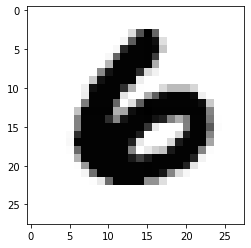

In [95]:
# last,Get one and predict
import matplotlib.pyplot as plt
import random
r = random.randint(0, mnist.test.num_examples - 1)
print("Label:", sess.run(tf.argmax(mnist.test.labels[r:r+1], 1)))
print("Prediction:", sess.run(tf.argmax(y_conv, 1),feed_dict={x: mnist.test.images[r:r + 1],keep_prob:1}))
plt.imshow(mnist.test.images[r:r + 1].reshape(28, 28), cmap='Greys', interpolation='nearest')
plt.show()

#sess.close()